In [1]:
import math
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

# MedMNIST import
import medmnist
from medmnist import INFO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- MedMNIST Data setup ---
data_flag = 'retinamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', download=True)
numSamples = len(train_dataset)
                      

Using device: cuda
Using downloaded and verified file: C:\Users\alexr\.medmnist\retinamnist.npz


In [2]:
# Prepare data tensors 
def _get_tensor(ds, n):
    """Stack first n samples, convert to float32 in [0,1]."""
    imgs = []
    for i in range(n):
        x, _ = ds[i]
        if isinstance(x, torch.Tensor):
            t = x.float() / 255.0
        elif isinstance(x, np.ndarray):
            t = torch.from_numpy(x).float() / 255.0
            if t.ndim == 3:
                t = t.permute(2, 0, 1)
        else:
            t = TF.to_tensor(x)
        imgs.append(t[0])
    return torch.stack(imgs).to(device)

# Load and prepare dataset
X_raw = _get_tensor(train_dataset, numSamples)  # (N, H, W)
dim = X_raw[0].numel()  # e.g. 28*28 = 784
r = 25  # bottleneck / testing rank

# X Stuff
X = X_raw.view(numSamples, -1).T  # (dim, numSamples)
gammaX = 1 / (numSamples) * X @ X.T + 1e-5 * torch.eye(dim, device=device)
L_X = torch.linalg.cholesky(gammaX)  # (dim, dim)

# Perform SVD of L_X as in proof
U, S, Vh = torch.linalg.svd(L_X) 
U_r, S_r, Vh_r = U[:, :r], torch.diag(S[:r]), Vh[:r, :]
L_X_r = U_r @ S_r @ Vh_r
M_r = L_X_r @ torch.linalg.pinv(L_X)

Final average per-sample L2 training error (learned): 2.7307


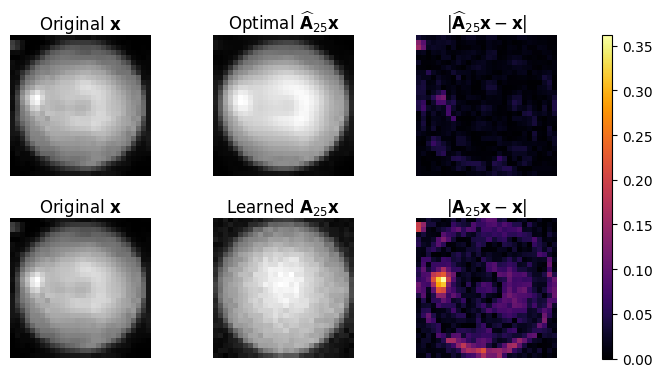

In [3]:
# --- Autoencoder setup -------------------------------------------------------
batch_size = 128
num_epochs = 200

# Define Linear Autoencoder model
class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=False)

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Instantiate model, optimizer, and loss
model     = LinearAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Prepare training data tensors
X_tensor = X.T  # Shape (numSamples, dim)
Y_tensor = X.T  # Here using X as both input/output since this is the identity reconstruction problem

# Training loop using average per-sample L2 error -----------------------------
train_errors = []
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    outputs = model(Y_tensor)
    target  = X_tensor

    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    # Evaluate and store error after each epoch
    with torch.no_grad():
        A_learned = model.decoder.weight @ model.encoder.weight

        diffs = A_learned @ X - X
        avg_l2_err = torch.norm(diffs, dim=0).mean().item()  # average per-sample l2 discrepancy

        train_errors.append(avg_l2_err)

print(f"Final average per-sample L2 training error (learned): {train_errors[-1]:.4f}")

# --- Compact 2×2 gallery comparing Optimal vs Learned reconstructions --------
from matplotlib import gridspec

# Example sample index for plotting
idx = 100

# Prepare images for plotting
x_img = X_raw[idx].view(28, 28).cpu()

opt_img   = (M_r @ X)[:, idx].view(28, 28).cpu()
learn_img = (A_learned @ X)[:, idx].view(28, 28).cpu()

# Errors
err_opt   = torch.abs(opt_img   - x_img)
err_learn = torch.abs(learn_img - x_img)
err_vmin, err_vmax = 0.0, max(err_opt.max(), err_learn.max()).item()

# Create 2×3 plot grid (Original | Reconstruction | Errors)
fig = plt.figure(figsize=(8, 4.2))
gs  = gridspec.GridSpec(
    2, 4,
    width_ratios=[1, 1, 1, 0.06],
    wspace=0.20, hspace=0.30
)

# row 0, col 0: Original image
ax = fig.add_subplot(gs[0, 0])
ax.imshow(x_img, cmap='gray')
ax.set_title(r'Original $\mathbf{x}$', pad=4)
ax.axis('off')

# row 0, col 1: Optimal reconstruction
ax = fig.add_subplot(gs[0, 1])
ax.imshow(opt_img, cmap='gray')
ax.set_title(r'Optimal $\widehat{\mathbf{A}}_{25} \mathbf{x}$', pad=4)
ax.axis('off')

# row 0, col 2: Optimal absolute error
ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(err_opt, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(r'$|\widehat{\mathbf{A}}_{25} \mathbf{x} - \mathbf{x}|$', pad=4)
ax.axis('off')

# row 1, col 0: Original image again
ax = fig.add_subplot(gs[1, 0])
ax.imshow(x_img, cmap='gray')
ax.set_title(r'Original $\mathbf{x}$', pad=4)
ax.axis('off')

# row 1, col 1: Learned reconstruction
ax = fig.add_subplot(gs[1, 1])
ax.imshow(learn_img, cmap='gray')
ax.set_title(r'Learned $\mathbf{A}_{25} \mathbf{x}$', pad=4)
ax.axis('off')

# row 1, col 2: Learned absolute error
ax = fig.add_subplot(gs[1, 2])
ax.imshow(err_learn, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(r'$|\mathbf{A}_{25} \mathbf{x} - \mathbf{x}|$', pad=4)
ax.axis('off')

# color-bar
cax = fig.add_subplot(gs[:, 3])
plt.colorbar(im, cax=cax)
cax.yaxis.tick_right()
plt.show()

In [ ]:
import os, pickle, torch
from collections import defaultdict
import matplotlib.pyplot as plt

# ── pastel-Everforest colours 
ef_pastel   = ['#a7c080', '#d3869b', "#83c0c0", '#e69875', '#a988b0', "#b8912f"]
line_styles = {'theory': '-',  'learned': '--'}
markers     = {'theory': 'o',  'learned': 's'}
lw, ms      = 1.5, 4

# ── where to stash matrices and final plots 
save_root = "Classic"
matrices_root = os.path.join(save_root, "MedMNIST", "Matrices")
tests_root    = os.path.join(save_root, "MedMNIST", "Pics")
os.makedirs(matrices_root, exist_ok=True)
os.makedirs(tests_root, exist_ok=True)

# helper: run rank sweep on ONE MedMNIST subset
def run_rank_sweep(data_flag, ranks, train_epochs=500, lr=1e-3):
    """Return ([theory avg l2], [AE avg l2]) for the given dataset
       and store matrices to pickles for every rank."""
    info        = INFO[data_flag]
    DataClass   = getattr(medmnist, info['python_class'])
    train_ds    = DataClass(split='train', download=True)

    numSamples  = len(train_ds)
    X_raw       = _get_tensor(train_ds, numSamples)
    dim         = X_raw[0].numel()

    # build data matrix X (not centered)
    X = X_raw.view(numSamples, -1).T  # (dim, numSamples)

    # compute empirical second moment matrix gammaX
    gammaX = 1 / (numSamples) * X @ X.T + 1e-5 * torch.eye(dim, device=device)

    # compute Cholesky factor L_X
    L_X = torch.linalg.cholesky(gammaX)  # (dim, dim)

    # SVD of L_X as in proof
    U, S, Vh = torch.linalg.svd(L_X)

    theory_err, learned_err = [], []
    ds_dir = os.path.join(matrices_root, data_flag)
    os.makedirs(ds_dir, exist_ok=True)

    for r in ranks:
        if r % 100 == 0:
            print(f"On Rank {r}")

        # Truncate SVD to rank-r and construct L_X_r
        U_r     = U[:, :r]
        S_r     = torch.diag(S[:r])
        Vh_r    = Vh[:r, :]
        L_X_r   = U_r @ S_r @ Vh_r

        # Bayes-optimal projection matrix M_r = L_X_r * pinv(L_X)
        M_r = L_X_r @ torch.linalg.pinv(L_X)

        # compute optimal reconstruction error
        X_opt = M_r @ X
        diffs_opt = X_opt - X
        avg_l2_opt = torch.norm(diffs_opt, dim=0).mean().item()
        theory_err.append(avg_l2_opt)

        # linear autoencoder learning
        ae = LinearAutoencoder(dim, r).to(device)
        opt = optim.Adam(ae.parameters(), lr=lr)

        for _ in range(train_epochs):
            opt.zero_grad()
            out = ae(X.T)
            loss = criterion(out, X.T)
            loss.backward()
            opt.step()

        with torch.no_grad():
            W_enc = ae.encoder.weight.detach().cpu()
            W_dec = ae.decoder.weight.detach().cpu()
            b_dec = ae.decoder.bias.detach().cpu() if ae.decoder.bias is not None else torch.zeros(dim)
            A_learned = W_dec @ W_enc

            X_learn = A_learned.to(device) @ X
            diffs_learn = X_learn - X
            avg_l2_learn = torch.norm(diffs_learn, dim=0).mean().item()
        learned_err.append(avg_l2_learn)

        # save matrices
        dump_path = os.path.join(ds_dir, f"rank_{r:03d}.pkl")
        with open(dump_path, "wb") as f:
            pickle.dump(
                {
                    "optimalMatrix": M_r.cpu(),
                    "encoderWeight": W_enc,
                    "decoderWeight": W_dec,
                },
                f,
                protocol=pickle.HIGHEST_PROTOCOL,
            )

    return theory_err, learned_err

# run all requested datasets (original sizes of: 200k, 100k, 50k, 10k, 1k)
datasets  = ['tissuemnist', 'chestmnist', 'organamnist', 'retinamnist']
ranks     = list(range(25, 776, 25))
results   = defaultdict(dict)
num_epochs = 200 # define here for training / plot naming

for flag in datasets:
    print(f"\n▶ Running rank sweep for {flag} …")
    th, le = run_rank_sweep(flag, ranks, train_epochs=num_epochs)
    results[flag]['theory']  = th
    results[flag]['learned'] = le


▶ Running rank sweep for tissuemnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\tissuemnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for chestmnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for organamnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\organamnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for retinamnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\retinamnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700


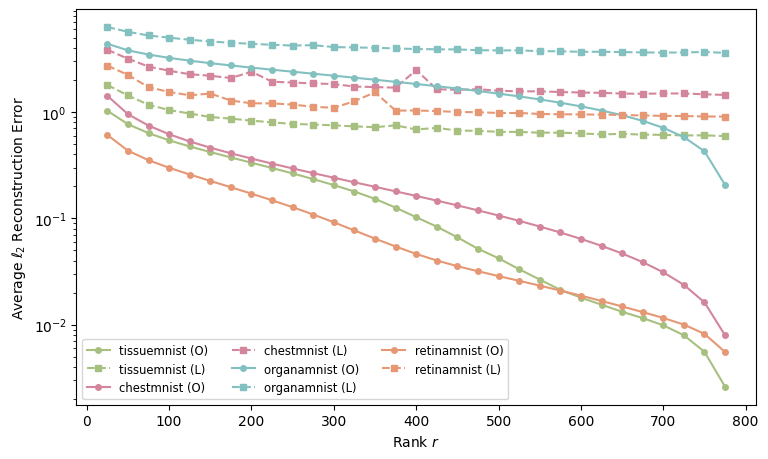

In [5]:
# combined plot
plt.figure(figsize=(7.8, 4.7))
short_label = {'theory': 'O', 'learned': 'L'}

for i, flag in enumerate(datasets):
    col = ef_pastel[i % len(ef_pastel)]
    for kind in ('theory', 'learned'):
        plt.plot(ranks,
                 results[flag][kind],
                 line_styles[kind],
                 marker=markers[kind],
                 color=col,
                 lw=lw,
                 ms=ms,
                 label=f"{flag} ({short_label[kind]})")


plt.xlabel('Rank $r$')
plt.ylabel(r'Average $\ell_2$ Reconstruction Error')
plt.yscale('log')
#plt.title('Average $\ell_2$ Error vs. Rank (Affine Linear)')
plt.legend(ncol=3, fontsize='small')
plt.tight_layout()

# Save final plot with shortened name including epoch info
plot_path = os.path.join(tests_root, f"classic_ranksweep_{num_epochs}ep.png")
plt.savefig(plot_path)
plt.show()

In [6]:
# ── Inspect stored matrices & compare singular values (4 decimals) ─────────
#    • Lists datasets / ranks, loads each pickle
#    • Computes singular values of
#        – Bayes–optimal map  Mr
#        – Learned map        A = W_dec @ W_enc
#    • Prints top-k singular values (rounded to 4 decimals) and relative ℓ2 error

import os, pickle, torch

base_dir  = "Classic/MedMNIST/Matrices"  # updated save path for Affine Linear sweep
top_k     = 10                              # how many singular values to show
torch.set_printoptions(edgeitems=3, linewidth=120, sci_mode=False)

for dataset in sorted(os.listdir(base_dir)):
    ds_dir = os.path.join(base_dir, dataset)
    if not os.path.isdir(ds_dir):
        continue

    print(f"\n══════════  {dataset.upper()}  ══════════")
    for fname in sorted(fn for fn in os.listdir(ds_dir) if fn.endswith(".pkl")):
        rank   = int(fname.split("_")[1].split(".")[0])        # rank_050.pkl → 50
        fpath  = os.path.join(ds_dir, fname)

        # ── load matrices ───────────────────────────────────────────────────
        with open(fpath, "rb") as f:
            mats = pickle.load(f)

        Mr   = mats["optimalMatrix"]
        Wenc = mats["encoderWeight"]
        Wdec = mats["decoderWeight"]
        #bvec = mats["biasVector"]       # also load biasVector if needed later
        A    = Wdec @ Wenc              # learned full map

        # ── singular values ────────────────────────────────────────────────
        s_opt    = torch.linalg.svdvals(Mr)
        s_learn  = torch.linalg.svdvals(A)

        rel_err = torch.norm(s_opt - s_learn) / torch.norm(s_opt)

        # Round singular values to 4 decimal places for print
        s_opt_rounded   = [round(v.item(), 4) for v in s_opt[:top_k]]
        s_learn_rounded = [round(v.item(), 4) for v in s_learn[:top_k]]

        print(f"\n— Rank {rank:3d} —  ({fpath})")
        print(f"Relative ℓ₂ error on singular values: {rel_err:.3e}")
        print(f"Top {top_k} σ(M_r):", s_opt_rounded)
        print(f"Top {top_k} σ(A)  :", s_learn_rounded)

        # Uncomment next lines if you want FULL singular value lists
        # print("\nAll σ(M_r):\n", s_opt.cpu())
        # print("\nAll σ(A):\n",   s_learn.cpu())



══════════  BREASTMNIST  ══════════

— Rank  25 —  (Classic/MedMNIST/Matrices\breastmnist\rank_025.pkl)
Relative ℓ₂ error on singular values: 8.493e-01
Top 10 σ(M_r): [0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999]
Top 10 σ(A)  : [2.6105, 2.2088, 2.1487, 2.0492, 2.0172, 1.9846, 1.9785, 1.9344, 1.9024, 1.8761]

— Rank  50 —  (Classic/MedMNIST/Matrices\breastmnist\rank_050.pkl)
Relative ℓ₂ error on singular values: 4.049e-01
Top 10 σ(M_r): [0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999]
Top 10 σ(A)  : [2.2077, 1.8908, 1.802, 1.7802, 1.6915, 1.6187, 1.6042, 1.5736, 1.5329, 1.5152]

— Rank  75 —  (Classic/MedMNIST/Matrices\breastmnist\rank_075.pkl)
Relative ℓ₂ error on singular values: 2.929e-01
Top 10 σ(M_r): [1.0, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999]
Top 10 σ(A)  : [2.1002, 1.6617, 1.6257, 1.5765, 1.5527, 1.5283, 1.5165, 1.5093, 1.4809, 1.4353]

— Rank 100 —  (Classic/MedMNIST/Matrices\b